<a href="https://colab.research.google.com/github/nhutnguyen1907/carBrand_classification-/blob/main/carClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Kiểm tra thiết bị **

In [ ]:
if torch.cuda.is_available():
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Current GPU Index: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Switching to CPU...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Number of available GPUs: 1
GPU Name: Tesla T4
Current GPU Index: 0


In [ ]:
device

device(type='cuda')

**Chuẩn bị Model**

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel().to(device)

**Chuẩn bị dataset**

In [ ]:


train_directory = '/content/drive/MyDrive/AI/carDetec/train'
test_directory = '/content/drive/MyDrive/AI/carDetec/test'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = datasets.ImageFolder(train_directory, transform=train_transform)
test_data = datasets.ImageFolder(test_directory, transform=test_transform)
batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

**Train Model**

In [ ]:
from tqdm import tqdm
torch.backends.cudnn.benchmark = True


learning_rate = 0.001
num_epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_loss = []
prediction_loss = []

for epoch in tqdm(range(num_epochs)):
    #training
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_data)
    training_loss.append(epoch_loss)

    #test
    model.eval()
    correct = 0
    total = 0
    running_prediction_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_prediction_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_prediction_loss = running_prediction_loss / len(test_data)
    prediction_loss.append(epoch_prediction_loss)

    accuracy = correct / total
    print(f"""Epoch [{epoch + 1}/{num_epochs}],
    Training Loss: {training_loss[epoch]:.4f}, Prediction Loss: {prediction_loss[epoch]:.4f}, Accuracy on test set: {accuracy:.2%}""")

  2%|▏         | 1/50 [20:13<16:30:51, 1213.31s/it]

Epoch [1/50], 
    Training Loss: 1.7807, Prediction Loss: 1.5747, Accuracy on test set: 41.82%


  4%|▍         | 2/50 [20:57<7:00:39, 525.82s/it]  

Epoch [2/50], 
    Training Loss: 1.4565, Prediction Loss: 1.3958, Accuracy on test set: 52.28%


  6%|▌         | 3/50 [21:42<3:59:36, 305.89s/it]

Epoch [3/50], 
    Training Loss: 1.1115, Prediction Loss: 1.2512, Accuracy on test set: 58.79%


  8%|▊         | 4/50 [22:26<2:35:18, 202.57s/it]

Epoch [4/50], 
    Training Loss: 0.8066, Prediction Loss: 1.0740, Accuracy on test set: 64.45%


 10%|█         | 5/50 [23:10<1:49:11, 145.60s/it]

Epoch [5/50], 
    Training Loss: 0.5396, Prediction Loss: 1.1488, Accuracy on test set: 66.30%


 12%|█▏        | 6/50 [23:55<1:21:36, 111.29s/it]

Epoch [6/50], 
    Training Loss: 0.3905, Prediction Loss: 1.2490, Accuracy on test set: 65.19%


 14%|█▍        | 7/50 [24:39<1:04:06, 89.45s/it] 

Epoch [7/50], 
    Training Loss: 0.3104, Prediction Loss: 1.2546, Accuracy on test set: 66.30%


 16%|█▌        | 8/50 [25:25<52:43, 75.33s/it]  

Epoch [8/50], 
    Training Loss: 0.1948, Prediction Loss: 1.5358, Accuracy on test set: 65.81%


 18%|█▊        | 9/50 [26:10<45:02, 65.90s/it]

Epoch [9/50], 
    Training Loss: 0.1614, Prediction Loss: 1.5238, Accuracy on test set: 67.40%


 20%|██        | 10/50 [26:55<39:37, 59.43s/it]

Epoch [10/50], 
    Training Loss: 0.1413, Prediction Loss: 1.5617, Accuracy on test set: 67.53%


 22%|██▏       | 11/50 [27:40<35:49, 55.12s/it]

Epoch [11/50], 
    Training Loss: 0.1222, Prediction Loss: 1.8500, Accuracy on test set: 65.19%


 24%|██▍       | 12/50 [28:24<32:46, 51.75s/it]

Epoch [12/50], 
    Training Loss: 0.1070, Prediction Loss: 1.6406, Accuracy on test set: 68.27%


 26%|██▌       | 13/50 [29:08<30:27, 49.40s/it]

Epoch [13/50], 
    Training Loss: 0.0972, Prediction Loss: 1.7509, Accuracy on test set: 65.19%


 28%|██▊       | 14/50 [29:53<28:48, 48.01s/it]

Epoch [14/50], 
    Training Loss: 0.0863, Prediction Loss: 2.0473, Accuracy on test set: 68.51%


 30%|███       | 15/50 [30:37<27:21, 46.89s/it]

Epoch [15/50], 
    Training Loss: 0.0666, Prediction Loss: 1.9549, Accuracy on test set: 67.77%


 32%|███▏      | 16/50 [31:22<26:10, 46.18s/it]

Epoch [16/50], 
    Training Loss: 0.0745, Prediction Loss: 1.8984, Accuracy on test set: 67.16%


 34%|███▍      | 17/50 [32:06<25:04, 45.60s/it]

Epoch [17/50], 
    Training Loss: 0.0763, Prediction Loss: 2.0615, Accuracy on test set: 66.05%


 36%|███▌      | 18/50 [32:50<24:04, 45.13s/it]

Epoch [18/50], 
    Training Loss: 0.0876, Prediction Loss: 2.1295, Accuracy on test set: 64.94%


 38%|███▊      | 19/50 [33:35<23:14, 44.99s/it]

Epoch [19/50], 
    Training Loss: 0.0701, Prediction Loss: 2.2622, Accuracy on test set: 65.56%


 40%|████      | 20/50 [34:20<22:29, 45.00s/it]

Epoch [20/50], 
    Training Loss: 0.0475, Prediction Loss: 2.0470, Accuracy on test set: 66.67%


 42%|████▏     | 21/50 [35:06<21:54, 45.32s/it]

Epoch [21/50], 
    Training Loss: 0.0668, Prediction Loss: 2.3106, Accuracy on test set: 67.90%


 44%|████▍     | 22/50 [35:51<21:07, 45.27s/it]

Epoch [22/50], 
    Training Loss: 0.0465, Prediction Loss: 2.6755, Accuracy on test set: 68.39%


 46%|████▌     | 23/50 [36:36<20:17, 45.09s/it]

Epoch [23/50], 
    Training Loss: 0.0639, Prediction Loss: 2.3866, Accuracy on test set: 69.62%


 48%|████▊     | 24/50 [37:20<19:28, 44.96s/it]

Epoch [24/50], 
    Training Loss: 0.0370, Prediction Loss: 2.4878, Accuracy on test set: 66.79%


 50%|█████     | 25/50 [38:04<18:35, 44.63s/it]

Epoch [25/50], 
    Training Loss: 0.0493, Prediction Loss: 2.8767, Accuracy on test set: 67.40%


 52%|█████▏    | 26/50 [38:49<17:50, 44.60s/it]

Epoch [26/50], 
    Training Loss: 0.0424, Prediction Loss: 2.5767, Accuracy on test set: 66.05%


 54%|█████▍    | 27/50 [39:33<17:02, 44.45s/it]

Epoch [27/50], 
    Training Loss: 0.0451, Prediction Loss: 3.2680, Accuracy on test set: 66.67%


 56%|█████▌    | 28/50 [40:17<16:13, 44.26s/it]

Epoch [28/50], 
    Training Loss: 0.0503, Prediction Loss: 3.2145, Accuracy on test set: 63.96%


 58%|█████▊    | 29/50 [41:01<15:27, 44.18s/it]

Epoch [29/50], 
    Training Loss: 0.0661, Prediction Loss: 2.5372, Accuracy on test set: 66.91%


 60%|██████    | 30/50 [41:45<14:43, 44.15s/it]

Epoch [30/50], 
    Training Loss: 0.0439, Prediction Loss: 2.7753, Accuracy on test set: 65.93%


 62%|██████▏   | 31/50 [42:29<13:57, 44.09s/it]

Epoch [31/50], 
    Training Loss: 0.0407, Prediction Loss: 3.2485, Accuracy on test set: 64.94%


 64%|██████▍   | 32/50 [43:12<13:11, 43.96s/it]

Epoch [32/50], 
    Training Loss: 0.0792, Prediction Loss: 2.9219, Accuracy on test set: 66.42%


 66%|██████▌   | 33/50 [43:56<12:24, 43.81s/it]

Epoch [33/50], 
    Training Loss: 0.0519, Prediction Loss: 3.0316, Accuracy on test set: 64.08%


 68%|██████▊   | 34/50 [44:39<11:37, 43.62s/it]

Epoch [34/50], 
    Training Loss: 0.0491, Prediction Loss: 3.1394, Accuracy on test set: 65.56%


 70%|███████   | 35/50 [45:22<10:52, 43.53s/it]

Epoch [35/50], 
    Training Loss: 0.0361, Prediction Loss: 3.0384, Accuracy on test set: 64.21%


 72%|███████▏  | 36/50 [46:06<10:10, 43.59s/it]

Epoch [36/50], 
    Training Loss: 0.0498, Prediction Loss: 3.3608, Accuracy on test set: 63.71%


 74%|███████▍  | 37/50 [46:50<09:26, 43.60s/it]

Epoch [37/50], 
    Training Loss: 0.0418, Prediction Loss: 4.0998, Accuracy on test set: 64.08%


 76%|███████▌  | 38/50 [47:33<08:44, 43.70s/it]

Epoch [38/50], 
    Training Loss: 0.0741, Prediction Loss: 3.2680, Accuracy on test set: 66.79%


 78%|███████▊  | 39/50 [48:18<08:01, 43.80s/it]

Epoch [39/50], 
    Training Loss: 0.0277, Prediction Loss: 3.1494, Accuracy on test set: 65.56%


 80%|████████  | 40/50 [49:01<07:17, 43.72s/it]

Epoch [40/50], 
    Training Loss: 0.0787, Prediction Loss: 4.1026, Accuracy on test set: 66.05%


 82%|████████▏ | 41/50 [49:45<06:34, 43.82s/it]

Epoch [41/50], 
    Training Loss: 0.0287, Prediction Loss: 3.2827, Accuracy on test set: 65.19%


 84%|████████▍ | 42/50 [50:29<05:51, 43.94s/it]

Epoch [42/50], 
    Training Loss: 0.0587, Prediction Loss: 2.8382, Accuracy on test set: 65.68%


 86%|████████▌ | 43/50 [51:13<05:06, 43.82s/it]

Epoch [43/50], 
    Training Loss: 0.0237, Prediction Loss: 3.9495, Accuracy on test set: 66.42%


 88%|████████▊ | 44/50 [51:57<04:23, 43.89s/it]

Epoch [44/50], 
    Training Loss: 0.0858, Prediction Loss: 4.3786, Accuracy on test set: 64.82%


 90%|█████████ | 45/50 [52:41<03:40, 44.07s/it]

Epoch [45/50], 
    Training Loss: 0.0473, Prediction Loss: 4.0804, Accuracy on test set: 63.96%


 92%|█████████▏| 46/50 [53:25<02:56, 44.00s/it]

Epoch [46/50], 
    Training Loss: 0.0194, Prediction Loss: 4.5838, Accuracy on test set: 66.67%


 94%|█████████▍| 47/50 [54:10<02:12, 44.15s/it]

Epoch [47/50], 
    Training Loss: 0.0537, Prediction Loss: 5.1806, Accuracy on test set: 63.71%


 96%|█████████▌| 48/50 [54:54<01:28, 44.19s/it]

Epoch [48/50], 
    Training Loss: 0.0671, Prediction Loss: 3.7179, Accuracy on test set: 63.59%


 98%|█████████▊| 49/50 [55:37<00:43, 43.93s/it]

Epoch [49/50], 
    Training Loss: 0.0300, Prediction Loss: 3.9014, Accuracy on test set: 65.56%


100%|██████████| 50/50 [56:21<00:00, 67.63s/it]

Epoch [50/50], 
    Training Loss: 0.0392, Prediction Loss: 4.8042, Accuracy on test set: 67.40%


In [ ]:
torch.save(model.state_dict(), 'car_classifier.pth')

**Visualize Model Training Process**

In [ ]:
import matplotlib.pyplot as plt
def loss_curve():
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(prediction_loss, label='Prediction Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

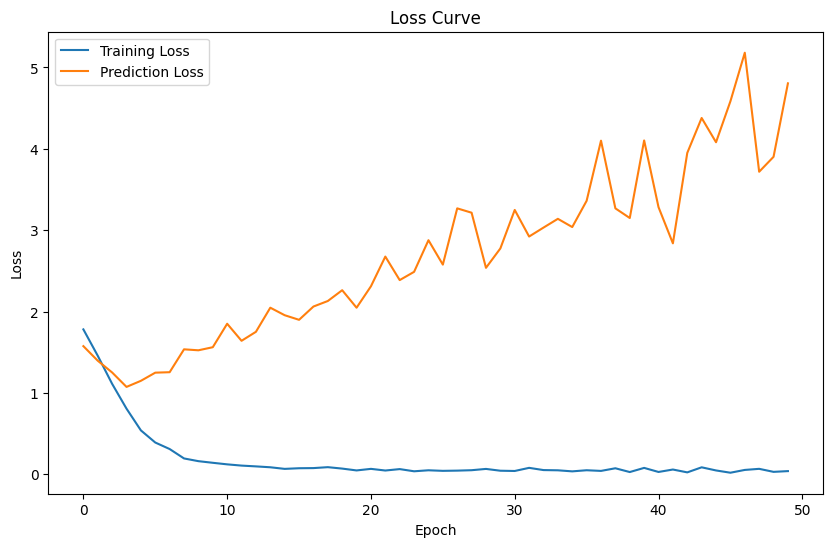

In [ ]:
loss_curve()

**Thử nghiệm dự đoán**

In [ ]:
from PIL import Image

model = CNNModel()
model.load_state_dict(torch.load('car_classifier.pth'))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open('/content/drive/MyDrive/AI/carDetec/test/Toyota Innova/1066.jpg')
image = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model(image)

probabilities = torch.softmax(output, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

if predicted_class == 0:
    print(f"Predicted class: Audi")
elif predicted_class == 1:
    print(f"Predicted class: Huyndai Creta")
elif predicted_class == 2:
    print(f"Predicted class: Mahindra Scorpio")
elif predicted_class == 3:
    print(f"Predicted class: Rolls Royce")
elif predicted_class == 4:
    print(f"Predicted class: Swift")
elif predicted_class == 5:
    print(f"Predicted class: Tata Safari")
else:
    print(f"Predicted class: Toyota Innova")

Predicted class: Toyota Innova


**Đánh giá mô hình**

Model trên đang overfiting do thiếu dataset
Với chỉ sấp sỉ 3200 bức ảnh cho việc phân loại xác định 7 hãng xe thì model chỉ dự đoán chính xác ~70%
Cần thêm data để tiếp tục việc huấn luyện trở nên chính xác hơn
